In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [ ]:
!pip install imbalanced-learn
import imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install xgboost
import xgboost as xgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt 
import seaborn as sns
train=pd.read_csv("/content/drive/MyDrive/Data/train.csv")
test=pd.read_csv("/content/drive/MyDrive/Data/test.csv")
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3424175,0,11053717,49.00,W,5033,269.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3206179,0,5150800,57.95,W,4527,376.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3410455,0,10713596,115.95,W,2772,512.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3058578,0,1611950,100.00,H,14290,512.0,150.0,visa,226.0,...,chrome 62.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
4,3242131,0,6111087,95.00,W,12839,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Pre-Processing & EDA**

First we check how much missing data does each column have.

In [ ]:
limit=(train["isFraud"].sum()/len(train))*100
train["isFraud"].sum()

15497

In [ ]:
columns=[]
emptytrainpercent=[]
for i in train:
    columns.append(i)
    percent=(train[i].isnull().sum())/len(train)
    percent=percent*100
    emptytrainpercent.append(percent)
list_of_tuples = list(zip(columns, emptytrainpercent))
emptytrainpercentdf=pd.DataFrame(list_of_tuples,columns=["Column Name","Empty %"])
emptytrainpercentdf=emptytrainpercentdf.sort_values(by="Empty %",ascending=False)
emptytrainpercentdf

,Column Name,Empty %
417,id_24,99.198022
418,id_25,99.132545
400,id_07,99.128030
401,id_08,99.128030
414,id_21,99.127352
...,...,...
19,C3,0.000000
18,C2,0.000000
17,C1,0.000000
1,isFraud,0.000000


In [ ]:
columns=[]
emptytestpercent=[]
for i in test:
    columns.append(i)
    percent=(test[i].isnull().sum())/len(test)
    percent=percent*100
    emptytestpercent.append(percent)
list_of_tuples1 = list(zip(columns, emptytestpercent))
emptytestpercentdf=pd.DataFrame(list_of_tuples1,columns=["Column Name","Empty %"])
emptytestpercentdf=emptytestpercentdf.sort_values(by="Empty %",ascending=False)
emptytestpercentdf

,Column Name,Empty %
416,id_24,99.190571
417,id_25,99.126223
400,id_08,99.124191
399,id_07,99.124191
413,id_21,99.123514
...,...,...
21,C6,0.000000
20,C5,0.000000
16,C1,0.000000
17,C2,0.000000


We remove all the columns which have more missing data then no. of frauds (very high amount of missing data, so columns are not useful)


In [ ]:
for ind in emptytrainpercentdf.index:
    if((100-emptytrainpercentdf["Empty %"][ind])<limit):
        train.drop([emptytrainpercentdf["Column Name"][ind]], axis=1,inplace=True)
        test.drop([emptytrainpercentdf["Column Name"][ind]], axis=1,inplace=True)
    else:
        break

Now we will try to reduce no. of V columns as they are the ones which are high in number and can be reduced. We will be start by sorting them based on the missing value percent.

In [ ]:
vcols=emptytrainpercentdf.loc[emptytrainpercentdf["Column Name"].str.startswith("V")]
vcols

,Column Name,Empty %
196,V142,86.137659
212,V158,86.137659
194,V140,86.137659
216,V162,86.137659
195,V141,86.137659
...,...,...
370,V316,0.001129
371,V317,0.001129
372,V318,0.001129
373,V319,0.001129


In [ ]:
vcols["Empty %"]=vcols["Empty %"].astype(int)
vcols

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Column Name,Empty %
196,V142,86
212,V158,86
194,V140,86
216,V162,86
195,V141,86
...,...,...
370,V316,0
371,V317,0
372,V318,0
373,V319,0


We observe that many of this columns have the same exact percent of missing data.
We will make groups according to that and make a correlation chart.

In [ ]:
temp1=vcols["Empty %"][196]
vgroups=[]
tempgroup=[]
for i in vcols.index:
    if(vcols["Empty %"][i]==temp1):
        tempgroup.append(vcols["Column Name"][i])
    else:
        vgroups.append(tempgroup)
        tempgroup=[]
        tempgroup.append(vcols["Column Name"][i])
        temp1=vcols["Empty %"][i]
vgroups.append(tempgroup)
len(vgroups)

9

In [ ]:
vgroups[0].sort()
vtemp=train[vgroups[0]]

In [ ]:
#plt.figure(figsize=(30,30))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group0 = ["V140", "V142", "V164", "V165", "V322", "V323", "V324", "V331", "V332", "V333", "V145", "V150", "V151", "V159", "V160", "V147", "V149", "V153", "V154", "V155", "V156", "V157", "V158", "V162", "V163", "V327", "V329", "V330", "V334", "V335", "V337", "V338"]
train.drop(axis = 1, labels = drop_group0, inplace = True)
test.drop(axis = 1, labels = drop_group0, inplace = True)
vgroup0 = []

In [ ]:
vgroups[1].sort()
vtemp = train[vgroups[1]]

In [ ]:
#plt.figure(figsize = (30,30))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group1 = ["V218", "V219", "V231", "V232", "V233", "V273", "V275", "V225", "V253", "V230", "V243", "V248", "V254", "V235", "V236", "V244", "V257", "V249", "V262", "V263", "V264", "V269", "V268", "V276", "V277"]
train.drop(axis = 1, labels = drop_group1, inplace = True)
test.drop(axis = 1, labels = drop_group1, inplace = True)
vgroup1 = []

In [ ]:
vgroups[2].sort()
vtemp = train[vgroups[2]]

In [ ]:
#plt.figure(figsize = (40,40))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group2 = ["V168", "V177", "V178", "V179", "V202", "V204", "V211", "V212", "V213", "V191", "V196", "V207", "V190", "V199", "V182", "V183", "V203", "V192", "V193", "V189", "V197", "V198", "V201", "V214", "V215", "V222", "V245", "V259", "V239", "V251", "V256", "V270", "V271"]
train.drop(axis = 1, labels = drop_group2, inplace = True)
test.drop(axis = 1, labels = drop_group2, inplace = True)
vgroup2 = []

In [ ]:
vgroups[3].sort()
vtemp = train[vgroups[3]]

In [ ]:
#plt.figure(figsize = (10,10))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group3 = ["V11", "V5"]
train.drop(axis = 1, labels = drop_group3, inplace = True)
test.drop(axis = 1, labels = drop_group3, inplace = True)
vgroup3 = []

In [ ]:
vgroups[4].sort()
vtemp = train[vgroups[4]]

In [ ]:
#plt.figure(figsize = (10,10))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group4 = ["V36", "V38", "V40", "V42", "V50", "V45", "V49", "V50", "V52"]
train.drop(axis = 1, labels = drop_group4, inplace = True)
test.drop(axis = 1, labels = drop_group4, inplace = True)
vgroup4 = []

In [ ]:
vgroups[5].sort()
vtemp = train[vgroups[5]]

In [ ]:
#plt.figure(figsize = (10, 10))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group5 = ["V76", "V92", "V93", "V94", "V81", "V84", "V83", "V93", "V87", "V91"]
train.drop(axis = 1, labels = drop_group5, inplace = True)
test.drop(axis = 1, labels = drop_group5, inplace = True)
vgroup5 = []

In [ ]:
vgroups[6].sort()
vtemp = train[vgroups[6]]

In [ ]:
#plt.figure(figsize = (15, 15))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group6 = ["V54", "V58", "V71", "V72", "V73", "V74", "V60", "V63", "V64", "V62", "V70"]
train.drop(axis = 1, labels = drop_group6, inplace = True)
test.drop(axis = 1, labels = drop_group6, inplace = True)
vgroup6 = []

In [ ]:
vgroups[7].sort()
vtemp = train[vgroups[7]]

In [ ]:
#plt.figure(figsize = (15, 15))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group7 = ["V13", "V16", "V31", "V32", "V33", "V34", "V18", "V21", "V22", "V20", "V28"]
train.drop(axis = 1, labels = drop_group7, inplace = True)
test.drop(axis = 1, labels = drop_group7, inplace = True)
vgroup7 = []

In [ ]:
vgroups[8].sort()
vtemp = train[vgroups[8]]

In [ ]:
#plt.figure(figsize = (50, 50))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group8 = ["V287", "V102", "V103", "V126", "V127", "V128", "V132", "V133", "V134", "V279", "V280", "V293", "V294", "V295", "V306", "V307", "V308", "V316", "V317", "V318", "V95", "V96", "V97", "V106", "V297", "V299", "V296", "V298", "V299", "V111", "V112", "V119", "V309", "V311", "V310", "V312", "V135", "V136", "V99", "V289", "V292", "V301", "V302", "V303", "V315", "V319", "V320"]
train.drop(axis = 1, labels = drop_group8, inplace = True)
test.drop(axis = 1, labels = drop_group8, inplace = True)
vgroup8 = []

In [ ]:
Cs = [x for x in train.columns.values.tolist() if x.startswith("C")]
ctemp = train[Cs]

In [ ]:
#plt.figure(figsize = (10, 10))
#sns.heatmap(ctemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group_c = ["C1", "C2", "C4", "C6", "C7", "C8", "C11", "C12", "C14", "C9"]
train.drop(axis = 1, labels = drop_group_c, inplace = True)
test.drop(axis = 1, labels = drop_group_c, inplace = True)

In [ ]:
d_clmn = [x for x in train.columns.values.tolist() if (x.startswith("D"))]
d_temp = train[d_clmn]

In [ ]:
#plt.figure(figsize = (10, 10))
#sns.heatmap(d_temp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group_d = ["D2", "D6", "D12", "D7"]
train.drop(axis = 1, labels = drop_group_d, inplace = True)
test.drop(axis = 1, labels = drop_group_d, inplace = True)

In [ ]:
Vs = [x for x in train.columns.values.tolist() if x.startswith("V")]
vtemp = train[Vs]

In [ ]:
#plt.figure(figsize = (50, 50))
#sns.heatmap(vtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group_v = ["V29","V30","V48","V69","V90","V41","V53","V57","V79","V39","V43","V59","V80","V85","V68","V89","V51","V65","V88","V90"]
train.drop(axis = 1, labels = drop_group_v, inplace = True)
test.drop(axis = 1, labels = drop_group_v, inplace = True)

In [ ]:
otherthanv=['TransactionID','isFraud','TransactionDT','TransactionAmt','ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','C3','C5','C10','C13','D1','D3','D4','D10','D11','D15','M1','M2','M3','M4','M6']
otvtemp = train[otherthanv]

In [ ]:
#plt.figure(figsize = (50, 50))
#sns.heatmap(otvtemp.corr(), vmin=-1, cmap="coolwarm", annot=True)

In [ ]:
drop_group_otv = ['TransactionDT']
train.drop(axis = 1, labels = drop_group_otv, inplace = True)
test.drop(axis = 1, labels = drop_group_otv, inplace = True)

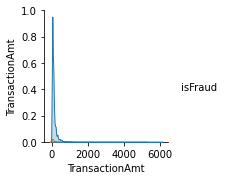

In [ ]:
sns.pairplot(train,vars=["TransactionAmt"],hue="isFraud")

In [ ]:
train["isFraud"].sum()

15497

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


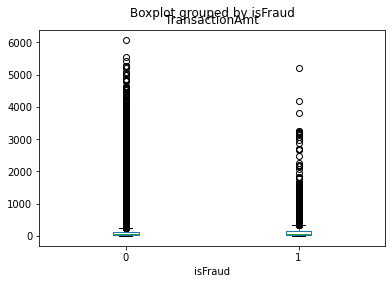

In [ ]:
train.boxplot(by ='isFraud', column =['TransactionAmt'], grid = False)

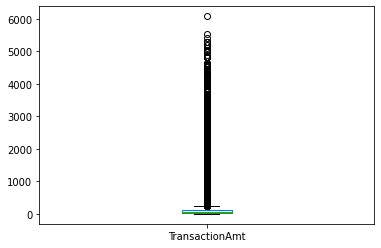

In [ ]:
train.boxplot( column =['TransactionAmt'], grid = False)

In [ ]:
skewness=train.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [ ]:
kurt=train.kurt()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [ ]:
kurt=kurt.to_frame()
skewness=skewness.to_frame()

In [ ]:
kurt=kurt.sort_values(by=0)
skewness=skewness.sort_values(by=0)

In [ ]:
for i in skewness.index:
    if(skewness[0][i]>5.1):
        train[i]=np.sqrt(train[i])
        test[i]=np.sqrt(test[i])
skewness=train.skew().to_frame().sort_values(by=0)
skewness

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,0
V1,-124.731178
V107,-47.251107
V14,-43.040684
V117,-27.476164
V120,-20.372119
...,...
C3,22.395746
V291,35.880862
V27,36.412255
V240,43.514011


In [ ]:
skewness=train.skew().to_frame().sort_values(by=0)
skewness

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,0
V1,-124.731178
V107,-47.251107
V14,-43.040684
V117,-27.476164
V120,-20.372119
...,...
C3,22.395746
V291,35.880862
V27,36.412255
V240,43.514011


In [ ]:
for i in skewness.index:
    if(skewness[0][i]<-4):
        train[i]=np.square(train[i])
        test[i]=np.square(test[i])
skewness=train.skew().to_frame().sort_values(by=0)
skewness

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,0
V1,-124.731178
V107,-47.251107
V14,-43.040684
addr2,-12.140090
id_11,-4.773276
...,...
id_04,43.709276
id_10,45.311314
id_09,45.801781
V241,95.812930


In [ ]:
for ind in skewness.index:
    if(skewness[0][ind]<-4):
        train.drop([ind], axis=1,inplace=True)
        test.drop([ind], axis=1,inplace=True)
skewness=train.skew().to_frame().sort_values(by=0)
skewness

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,0
id_06,-3.898825
id_01,-3.676057
V25,-2.654395
V195,-2.420624
id_13,-1.260213
...,...
id_04,43.709276
id_10,45.311314
id_09,45.801781
V241,95.812930


In [ ]:
for ind in skewness.index:
    if(skewness[0][ind]>10):
        train.drop([ind], axis=1,inplace=True)
        test.drop([ind], axis=1,inplace=True)
skewness=train.skew().to_frame().sort_values(by=0)
skewness

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,0
id_06,-3.898825
id_01,-3.676057
V25,-2.654395
V195,-2.420624
id_13,-1.260213
...,...
V229,8.705682
V265,8.949062
V226,9.172801
V161,9.723159


In [ ]:
train

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3424175,0,7.000000,W,5033,269.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3206179,0,7.612490,W,4527,376.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3410455,0,10.768008,W,2772,512.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3058578,0,10.000000,H,14290,512.0,150.0,visa,226.0,debit,...,chrome 62.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
4,3242131,0,9.746794,W,12839,321.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442900,3020019,0,5.385165,W,3277,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442901,3546388,0,9.848858,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442902,3087445,0,10.000000,R,6019,583.0,150.0,visa,226.0,credit,...,safari generic,24.0,2560x1600,match_status:2,T,F,F,F,desktop,MacOS
442903,3066953,0,5.000000,H,10737,399.0,150.0,american express,118.0,credit,...,mobile safari generic,32.0,2436x1125,match_status:2,T,F,F,T,mobile,iOS Device


In [ ]:
columns=[]
emptytrainpercent=[]
for i in train:
    columns.append(i)
    percent=(train[i].isnull().sum())/len(train)
    percent=percent*100
    emptytrainpercent.append(percent)
list_of_tuples = list(zip(columns, emptytrainpercent))
emptytrainpercentdf=pd.DataFrame(list_of_tuples,columns=["Column Name","Empty %"])
emptytrainpercentdf=emptytrainpercentdf.sort_values(by="Empty %",ascending=False)
emptytrainpercentdf

,Column Name,Empty %
12,dist2,93.640171
164,id_18,92.371276
25,D13,89.545162
26,D14,89.485330
155,id_03,88.777277
...,...,...
3,ProductCD,0.000000
4,card1,0.000000
16,C13,0.000000
1,isFraud,0.000000


In [ ]:
for ind in emptytrainpercentdf.index:
    if((100-emptytrainpercentdf["Empty %"][ind])<25 and emptytrainpercentdf["Column Name"][ind]!="R_emaildomain"):
        train.drop([emptytrainpercentdf["Column Name"][ind]], axis=1,inplace=True)
        test.drop([emptytrainpercentdf["Column Name"][ind]], axis=1,inplace=True)

In [ ]:
columns=[]
emptytrainpercent=[]
for i in train:
    columns.append(i)
    percent=(train[i].isnull().sum())/len(train)
    percent=percent*100
    emptytrainpercent.append(percent)
list_of_tuples = list(zip(columns, emptytrainpercent))
emptytrainpercentdf=pd.DataFrame(list_of_tuples,columns=["Column Name","Empty %"])
emptytrainpercentdf=emptytrainpercentdf.sort_values(by="Empty %",ascending=False)
emptytrainpercentdf

,Column Name,Empty %
13,R_emaildomain,76.805861
11,dist1,59.672164
27,M5,59.322202
29,M7,58.668112
31,M9,58.665854
...,...,...
14,C5,0.000000
4,card1,0.000000
3,ProductCD,0.000000
2,TransactionAmt,0.000000


In [ ]:
train["isFraud"].sum()

15497

In [ ]:
t1=train["P_emaildomain"].unique()

In [ ]:
out = [d for _, d in train.groupby('isFraud')]

In [ ]:
t2=out[1]["P_emaildomain"].unique()

In [ ]:
l=[]
for i in train.index:
    l.append(0)
l2=[]
for i in test.index:
    l2.append(0)
train["P"]=l
test["P"]=l2

In [ ]:
for i in train.index:
    if(train["P_emaildomain"][i] in t2):
        train["P"][i]=1
for i in test.index:
    if(test["P_emaildomain"][i] in t2):
        test["P"][i]=1     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
drop_group_p = ['P_emaildomain']
train.drop(axis = 1, labels = drop_group_p, inplace = True)
test.drop(axis = 1, labels = drop_group_p, inplace = True)

In [ ]:
t1=train["R_emaildomain"].unique()
t2=out[1]["R_emaildomain"].unique()
l=[]
for i in train.index:
    l.append(0)
l2=[]
for i in test.index:
    l2.append(0)
train["R"]=l
test["R"]=l2
for i in train.index:
    if(train["R_emaildomain"][i] in t2):
        train["R"][i]=1
for i in test.index:
    if(test["R_emaildomain"][i] in t2):
        test["R"][i]=1
drop_group_r = ['R_emaildomain']
train.drop(axis = 1, labels = drop_group_r, inplace = True)
test.drop(axis = 1, labels = drop_group_r, inplace = True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
train["M4"].fillna("M3",inplace=True)
test["M4"].fillna("M3",inplace=True)

In [ ]:
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]) or pd.api.types.is_float_dtype(train[col]):
        if train[col].nunique()<=10:
            train[col].fillna(train[col].median(),inplace=True)
            if(col!="isFraud"):
                test[col].fillna(train[col].median(),inplace=True)
        else:
            train[col].fillna(train[col].mean(),inplace=True)
            if(col!="isFraud"):
                test[col].fillna(train[col].mean(),inplace=True)

In [ ]:
columns=[]
emptytrainpercent=[]
for i in train:
    columns.append(i)
    percent=(train[i].isnull().sum())/len(train)
    percent=percent*100
    emptytrainpercent.append(percent)
list_of_tuples = list(zip(columns, emptytrainpercent))
emptytrainpercentdf=pd.DataFrame(list_of_tuples,columns=["Column Name","Empty %"])
emptytrainpercentdf=emptytrainpercentdf.sort_values(by="Empty %",ascending=False)
emptytrainpercentdf

,Column Name,Empty %
25,M5,59.322202
27,M7,58.668112
28,M8,58.665854
29,M9,58.665854
23,M3,45.920005
...,...,...
36,V9,0.000000
35,V8,0.000000
34,V7,0.000000
33,V6,0.000000


In [ ]:
train["M1"].value_counts()

T    239505
F        18
Name: M1, dtype: int64

In [ ]:
train["M1"].fillna("T",inplace=True)
test["M1"].fillna("T",inplace=True)

In [ ]:
train["M2"].value_counts()

T    214073
F     25450
Name: M2, dtype: int64

In [ ]:
train["M2"].fillna("N",inplace=True)
test["M2"].fillna("N",inplace=True)

In [ ]:
train["M3"].value_counts()

T    188857
F     50666
Name: M3, dtype: int64

In [ ]:
train["M3"].fillna("N",inplace=True)
test["M3"].fillna("N",inplace=True)

In [ ]:
train["M6"].value_counts()

F    171103
T    145016
Name: M6, dtype: int64

In [ ]:
train["M6"].fillna("N",inplace=True)
test["M6"].fillna("N",inplace=True)

In [ ]:
train["card4"].value_counts()

visa                288368
mastercard          142101
american express      6274
discover              4971
Name: card4, dtype: int64

In [ ]:
train["card4"].fillna("others",inplace=True)
test["card4"].fillna("others",inplace=True)

In [ ]:
train["card6"].value_counts()

debit              329967
credit             111718
debit or credit        24
charge card            11
Name: card6, dtype: int64

In [ ]:
train["card6"].fillna("debit",inplace=True)
test["card6"].fillna("debit",inplace=True)

In [ ]:
columns=[]
emptytrainpercent=[]
for i in train:
    columns.append(i)
    percent=(train[i].isnull().sum())/len(train)
    percent=percent*100
    emptytrainpercent.append(percent)
list_of_tuples = list(zip(columns, emptytrainpercent))
emptytrainpercentdf=pd.DataFrame(list_of_tuples,columns=["Column Name","Empty %"])
emptytrainpercentdf=emptytrainpercentdf.sort_values(by="Empty %",ascending=False)
emptytrainpercentdf

,Column Name,Empty %
25,M5,59.322202
27,M7,58.668112
28,M8,58.665854
29,M9,58.665854
49,V47,0.000000
...,...,...
32,V4,0.000000
31,V3,0.000000
30,V2,0.000000
26,M6,0.000000


In [ ]:
train["M5"].value_counts()

F    99584
T    80580
Name: M5, dtype: int64

In [ ]:
train["M5"].fillna("N",inplace=True)
test["M5"].fillna("N",inplace=True)

In [ ]:
train["M7"].value_counts()

F    158440
T     24621
Name: M7, dtype: int64

In [ ]:
train["M7"].fillna("F",inplace=True)
test["M7"].fillna("F",inplace=True)

In [ ]:
train["M8"].value_counts()

F    116401
T     66670
Name: M8, dtype: int64

In [ ]:
train["M8"].fillna("N",inplace=True)
test["M8"].fillna("N",inplace=True)

In [ ]:
train["M9"].value_counts()

T    154135
F     28936
Name: M9, dtype: int64

In [ ]:
train["M9"].fillna("F",inplace=True)
test["M9"].fillna("F",inplace=True)

In [ ]:
columns=[]
emptytestpercent=[]
for i in test:
    columns.append(i)
    percent=(test[i].isnull().sum())/len(test)
    percent=percent*100
    emptytestpercent.append(percent)
list_of_tuples1 = list(zip(columns, emptytestpercent))
emptytestpercentdf=pd.DataFrame(list_of_tuples1,columns=["Column Name","Empty %"])
emptytestpercentdf=emptytestpercentdf.sort_values(by="Empty %",ascending=False)
emptytestpercentdf

,Column Name,Empty %
0,TransactionID,0.0
58,V86,0.0
67,V115,0.0
66,V114,0.0
65,V113,0.0
...,...,...
28,M9,0.0
27,M8,0.0
26,M7,0.0
25,M6,0.0


In [ ]:
label_encoder = LabelEncoder()
one_hot_columns=[]
for col in train.columns:
    if not (pd.api.types.is_numeric_dtype(train[col]) or pd.api.types.is_float_dtype(train[col])):
        if train[col].nunique()<=2:
            train[col] = label_encoder.fit_transform(train[col])
            test[col] = label_encoder.fit_transform(test[col])
        else:
            one_hot_columns.append(col)
train= pd.get_dummies(train, columns =one_hot_columns)
test= pd.get_dummies(test, columns =one_hot_columns)


In [ ]:
train

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C5,...,M4_M3,M5_F,M5_N,M5_T,M6_F,M6_N,M6_T,M8_F,M8_N,M8_T
0,3424175,0,7.000000,5033,269.0,150.0,224.0,330.0,2.449490,0.000000,...,0,0,0,1,1,0,0,0,1,0
1,3206179,0,7.612490,4527,376.0,150.0,226.0,441.0,5.986395,1.000000,...,1,0,1,0,1,0,0,0,1,0
2,3410455,0,10.768008,2772,512.0,150.0,226.0,143.0,3.741657,1.000000,...,1,0,1,0,0,0,1,1,0,0
3,3058578,0,10.000000,14290,512.0,150.0,226.0,177.0,5.986395,0.000000,...,1,0,1,0,0,1,0,0,1,0
4,3242131,0,9.746794,12839,321.0,150.0,226.0,220.0,2.449490,11.916375,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442900,3020019,0,5.385165,3277,111.0,150.0,226.0,231.0,5.986395,0.000000,...,0,0,0,1,1,0,0,0,1,0
442901,3546388,0,9.848858,18132,567.0,150.0,117.0,272.0,2.828427,0.000000,...,0,0,0,1,1,0,0,0,1,0
442902,3087445,0,10.000000,6019,583.0,150.0,226.0,441.0,5.986395,0.000000,...,1,0,1,0,0,1,0,0,1,0
442903,3066953,0,5.000000,10737,399.0,150.0,118.0,204.0,5.986395,0.000000,...,1,0,1,0,0,1,0,0,1,0


In [ ]:
test

,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C5,C13,...,M4_M3,M5_F,M5_N,M5_T,M6_F,M6_N,M6_T,M8_F,M8_N,M8_T
0,3460689,18.027756,12932,361.0,150.0,226.0,126.000000,4.898979,0.0,0.000000,...,0,0,0,1,0,0,1,1,0,0
1,3415050,6.103851,14276,177.0,185.0,137.0,290.654596,5.986395,0.0,0.000000,...,0,0,1,0,0,1,0,0,1,0
2,3408682,10.000000,16506,554.0,150.0,226.0,299.000000,5.986395,0.0,1.000000,...,1,0,1,0,0,1,0,0,1,0
3,3389297,7.612490,9500,321.0,150.0,226.0,441.000000,17.175564,1.0,1.414214,...,1,0,1,0,1,0,0,1,0,0
4,3366334,5.853033,15885,545.0,185.0,138.0,284.000000,5.986395,0.0,1.000000,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147630,3193088,57.798270,7676,512.0,150.0,226.0,420.000000,5.986395,1.0,1.000000,...,1,0,1,0,0,1,0,0,1,0
147631,3400907,13.076697,2772,512.0,150.0,226.0,226.000000,8.717798,0.0,1.732051,...,0,1,0,0,0,0,1,0,1,0
147632,3489602,20.123369,7919,194.0,150.0,166.0,436.000000,6.324555,1.0,1.732051,...,1,0,1,0,0,0,1,0,1,0
147633,3534022,5.995832,11839,490.0,150.0,226.0,123.000000,5.986395,1.0,1.000000,...,1,0,1,0,0,0,1,0,0,1


In [ ]:
tol1=train

In [ ]:
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]) or pd.api.types.is_float_dtype(train[col]):
        if train[col].nunique()>10 and train[col].nunique()!=train.shape[0]:
            upper_limit = np.percentile(train[col],98)
            lower_limit = np.percentile(train[col],2)
            print(col)
            print(upper_limit)
            print(lower_limit)
            tol1[col] = np.where(train[col]>upper_limit,
                                  upper_limit,
                                  np.where(train[col]<lower_limit,
                                        lower_limit,
                                        train[col]
                                    )
                                )

TransactionAmt
27.820855486487112
3.5813405311419353
card1
18132.0
1545.0
card2
583.0
104.0
card3
185.0
150.0
card5
226.0
102.0
addr1
498.0
123.0
dist1
29.257477676655586
0.0
C5
10.862780491200215
0.0
C13
22.20360331117452
0.0
D1
566.0
0.0
D3
173.0
0.0
D4
581.0
0.0
D5
277.0
0.0
D10
588.0
0.0
D11
552.0
0.0
D15
607.0
0.0
V17
1.0
0.0
V23
1.4142135623730951
1.0
V24
1.4142135623730951
1.0
V26
1.0
0.0
V37
1.4142135623730951
1.0
V55
1.4142135623730951
1.0
V56
1.4142135623730951
1.0
V77
1.4142135623730951
1.0
V78
1.4142135623730951
1.0
V86
1.4142135623730951
1.0
V98
1.0
0.0
V100
1.7320508075688772
0.0
V104
1.0
0.0
V123
1.4142135623730951
1.0
V124
1.4142135623730951
1.0
V125
1.4142135623730951
1.0
V129
10.816653826391969
0.0
V130
30.0
0.0
V131
19.1049731745428
0.0
V281
1.0
0.0
V282
3.0
0.0
V283
2.23606797749979
0.0
V284
1.0
0.0
V285
2.8284271247461903
0.0
V288
1.0
0.0
V300
1.0
0.0
V304
1.0
0.0
V313
15.033296378372908
0.0
V314
22.247472040819183
0.0
V321
15.297058540778355
0.0


In [ ]:
train.to_csv("/pre_processed_train.csv")

In [ ]:
test.to_csv("/pre_processed_test.csv")

In [ ]:
ytrain=train["isFraud"]
train.drop(axis = 1, labels = ["isFraud"], inplace = True)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.04)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over),('u',under)]
pipeline = Pipeline(steps=steps)
train1, ytrain1 = pipeline.fit_resample(train, ytrain)

In [ ]:
train1

,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,dist1,C5,C13,...,M4_M3,M5_F,M5_N,M5_T,M6_F,M6_N,M6_T,M8_F,M8_N,M8_T
0,3389563,4.410782,15885.000000,545.000000,185.00000,138.000000,290.654596,5.986395,0.000000,1.000000,...,0,0,1,0,0,1,0,0,1,0
1,3085609,7.071068,8437.000000,478.000000,150.00000,166.000000,204.000000,5.986395,0.000000,1.000000,...,1,0,1,0,0,1,0,0,1,0
2,3439468,10.389899,14025.000000,479.000000,150.00000,226.000000,143.000000,5.986395,10.392305,20.615528,...,1,0,1,0,0,0,1,0,1,0
3,3248399,15.033296,7919.000000,194.000000,150.00000,202.000000,498.000000,5.986395,0.000000,1.732051,...,0,0,0,1,1,0,0,0,1,0
4,3066421,10.389899,2455.000000,321.000000,150.00000,226.000000,310.000000,4.898979,1.000000,2.645751,...,1,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38461,3384970,3.625840,9917.000000,142.000000,185.00000,138.000000,290.654596,5.986395,0.000000,1.967698,...,0,0,1,0,0,1,0,0,1,0
38462,3461744,17.562323,5539.087130,297.749318,150.00000,211.745224,296.714741,5.366658,0.858539,2.417794,...,0,0,0,0,0,0,0,0,0,0
38463,3387666,6.852302,12632.214894,440.402773,176.52072,158.561598,298.975290,5.986395,0.000000,0.242265,...,0,0,0,0,0,0,0,0,0,0
38464,3207185,6.693038,14997.234851,374.564564,150.00000,225.797021,287.949436,5.378839,0.000000,0.202979,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
ytrain1

NameError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
train1= scale.fit_transform(train1) 

In [ ]:
train1

array([[ 0.61546339, -1.05098346,  1.26859542, ..., -0.52510596,
         0.72492794, -0.36109387],
       [-1.20795006, -0.55170899, -0.26969544, ..., -0.52510596,
         0.72492794, -0.36109387],
       [ 0.9148424 ,  0.07115936,  0.88443578, ..., -0.52510596,
         0.72492794, -0.36109387],
       ...,
       [ 0.60408333, -0.59276632,  0.59677351, ..., -0.52510596,
        -1.37944745, -0.36109387],
       [-0.47861827, -0.62265651,  1.08523868, ..., -0.52510596,
         0.72492794, -0.36109387],
       [-1.69334539, -0.62104899,  0.09667493, ..., -0.52510596,
         0.72492794, -0.36109387]])

In [ ]:
test1 = scale.transform(test) 

In [ ]:
test1

array([[ 1.04214672e+00,  1.50460970e+00,  6.58690354e-01, ...,
         1.90437755e+00, -1.37944745e+00, -3.61093874e-01],
       [ 7.68359352e-01, -7.33233311e-01,  9.36276675e-01, ...,
        -5.25105960e-01,  7.24927944e-01, -3.61093874e-01],
       [ 7.30157859e-01, -2.01571492e-03,  1.39685517e+00, ...,
        -5.25105960e-01,  7.24927944e-01, -3.61093874e-01],
       ...,
       [ 1.21559518e+00,  1.89790813e+00, -3.76681839e-01, ...,
        -5.25105960e-01,  7.24927944e-01, -3.61093874e-01],
       [ 1.48206980e+00, -7.53506063e-01,  4.32944931e-01, ...,
        -5.25105960e-01, -1.37944745e+00,  2.76936296e+00],
       [-1.48363911e+00, -9.43483793e-01,  1.26859542e+00, ...,
        -5.25105960e-01,  7.24927944e-01, -3.61093874e-01]])

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 1,max_iter=100000)
classifier1 = LogisticRegression(random_state = 1,max_iter=100000)
classifier.fit(train1, ytrain1)
y_pred1 = classifier.predict(test1)

In [ ]:
y_pred1.sum()

31232

In [ ]:
import csv
with open('/log_reg.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id","isFraud"])
    idx=0
    for i in y_pred1:
        writer.writerow([idx,i])
        idx=idx+1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf1 = RandomForestClassifier(n_estimators = 100)
clf.fit(train1, ytrain1)
y_predrf1 = clf.predict(test1)

In [ ]:
y_predrf1.sum()

17625

In [ ]:
import csv
with open('/ran_for.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id","isFraud"])
    idx=0
    for i in y_predrf1:
        writer.writerow([idx,i])
        idx=idx+1

In [ ]:
from sklearn import linear_model
SGDClf = linear_model.SGDClassifier(max_iter = 100000, tol=1e-3,penalty = "elasticnet")
SGDClf1 = linear_model.SGDClassifier(max_iter = 100000, tol=1e-3,penalty = "elasticnet")
SGDClf.fit(train1, ytrain1)
y_predsvc1 = SGDClf.predict(test1)

In [ ]:
y_predsvc1.sum()

31373

In [ ]:
import csv
with open('/ans2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id","isFraud"])
    idx=0
    for i in y_predsvc1:
        writer.writerow([idx,i])
        idx=idx+1

In [ ]:
xgb_cl1 = xgb.XGBClassifier(learning_rate=1e-3,max_depth=5,subsample=0.75,colsample_bytree=0.75)
xgb_cl2 = xgb.XGBClassifier(learning_rate=1e-3,max_depth=5,subsample=0.75,colsample_bytree=0.75)
xgb_cl1.fit(train1, ytrain1)
preds1 = xgb_cl1.predict(test1)

In [ ]:
preds1.sum()

24776

In [ ]:
import csv
with open('/ans3.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id","isFraud"])
    idx=0
    for i in preds1:
        writer.writerow([idx,i])
        idx=idx+1